# Chapter 8. 차원 축소

**차원 축소(dimensionality reduction)**:특성 수를 크게 줄여서 불가능한 문제를 가능한 범위로 변경하는 방법  

<차원 축소의 장점>  
* 훈련 속도를 높일 수 있음
* 데이터 시각화에도 유용함

# 기본 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 8.1 차원의 저주

**차원의 저주(curse of dimensionality)**: 머신러닝 문제에서 많은 특성으로 인해 훈련이 느려지고 좋은 솔루션을 찾기 어려운 상황  

일반적으로 **훈련 세트의 차원이 클수록 과대적합 위험이 커짐**  

# 8.2 차원 축소를 위한 접근 방법

## 8.2.1 투영

교재에 있는 **<그림 8-2> 2차원에 가깝게 배치된 3차원 데이터셋**을 보면 모든 훈련 샘플이 거의 평면 형태로 놓여 있음(이게 고차원(3D) 공간에 있는 저차원(2D) **부분 공간(subspace)**임)  

여기서 모든 훈련 샘플을 이 **부분 공간**에 수직으로(즉, 샘플과 평면 사이의 가장 짧은 직선을 따라) **투영**하면 교재의 <그림 8-3>과 같은 2D 데이터셋을 얻을 수 있음  

## 8.2.2 매니폴드 학습

차원 축소에 있어서 앞서 얘기한 **투영**이 언제나 최선의 방법은 아님. **투영** 시 많은 경우 부분 공간이 롤케이크 모양처럼 뒤틀리거나 휘어 있기도 함  

이럴 때는 **매니폴드 학습**을 사용함  

**매니폴드 학습(manifold learning)**: 고차원의 데이터가 있을 때 고차원의 데이터를 저차원으로 옮길 때 데이터를 잘 설명하는 집합의 모형인 매니폴드가 있을 것이라고 가정하여 매니폴드를 부분 공간으로 삼아 차원 축소를 진행하는 방법

**<매니폴드의 개념>**  
* 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양을 말함
* 일반화하면 d차원 매니폴드는 국부적으로 d차원 초평면으로 보일 수 있는 n차원 공간의 일부라고 할 수 있음(d < n)  
* 매니폴드: 고차원의 데이터를 저차원으로 옮길 때 데이터를 잘 설명하는 집합의 모형

많은 차원 축소 알고리즘이 훈련 샘플에 놓여 있는 **매니폴드**를 모델링하는 식으로 작동함.  

**매니폴드 가정(매니폴드 가설)**: 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여있다는 가정  
이 **매니폴드 가정**은 종종 처리해야 할 작업(ex.분류 or 회귀)이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이란 가정과 병행되곤 함. **BUT** 교재의 <그림 8-6>에서 볼 수 있듯이 **데이터셋에 따라** 매니폴드 학습을 시켰을 때 결정 경계가 더 단순해지는 경우도 있고, 오히려 더 복잡해지는 경우도 있음  

지금까지 내용을 요약하면 모델 훈련 전 훈련 세트의 차원을 감소시키면 **훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아님**. 이는 전적으로 **데이터셋에 달렸음** 

# 8.3 PCA

**PCA(주성분 분석, Principal Component Analysis)**: 가장 인기 있는 차원 축소 알고리즘으로, 원본 데이터의 분포를 최대한 보존하면서 고차원 공간의 데이터들을 저차원 공간으로 변환하는 방법.  
이렇게 하기 위해서는 원본 데이터에 가장 가까운 **초평면(hyperplane)**을 정의한 뒤 데이터를 이 평면에 투영시킴  

## 8.3.1 분산 보존

저차원의 초평면에 훈련 세트를 투영하기 전 우선 **올바른 초평면**을 선택하는 것이 중요함  
**올바른 초평면**을 찾기위해 선택해야 하는 축은 **"분산이 최대로 보존되는"** 축, 즉 **원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는** 축임

## 8.3.2 주성분

PCA는 훈련 세트에서 **분산이 최대인 축**을 찾음  
그다음 **첫번째 축에 직교하고 남은 분산을 최대한 보존하는 두번째 축**을 찾음  
고차원 데이터셋인 경우 **이전의 두 축에 직교하는 세번째 축**을 찾음  

이때 <u>i번째 축</u>을 이 데이터의 **i번째 주성분(Principal Component, PC)**이라고 부름  

훈련 세트의 주성분은 **SVD(특잇값 분해, Singular Value Decomposition)**라는 표준 행렬 분해 기술을 사용하여 훈련 세트 행렬 X를 3개 행렬의 행렬 곱셈으로 분해할 수 있음(아래 식 참고)

$X = U \sum V^T$ 에서 $V$가 주성분

* (m, m) (m, n) (n, n)

m: 샘플 개수, n: 특성 개수

넘파이의 **svd() 함수**를 사용해 훈련 세트의 모든 주성분을 구한 후 처음 2개의 주성분을 정의하는 2개의 단위 벡터를 추출하는 방법은 아래와 같음

In [7]:
# 3D 데이터셋 생성
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [10]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

print("첫번째 주성분 단위벡터:", c1)
print("두번째 주성분 단위벡터:", c2)

첫번째 주성분 단위벡터: [0.93636116 0.29854881 0.18465208]
두번째 주성분 단위벡터: [-0.34027485  0.90119108  0.2684542 ]


## 8.3.3 d차원으로 투영하기

주성분을 모두 추출해냈다면, 처음 **d개의 주성분**으로 정의한 초평면에 투영하여 데이터셋의 차원을 **d차원으로 축소**시킬 수 있음  

초평면에 훈련 세트를 투영하고 d차원으로 축소된 데이터셋을 얻기 위해서는 **행렬 X**와 **V의 첫 $d$열로 구성된 행렬 W$_d$**를 행렬 곱셈하면 됨(교재의 <식 8-2> 참고)  

아래의 코드는 첫 2개의 주성분으로 정의된 평면에 훈련 세트를 투영함

In [12]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
print(X2D.shape)

(60, 2)


**행렬 X**의 크기가 (60, 3)이고 2개의 주성분이 담긴 **행렬 W$_d$**의 크기가 (3, 2)였기 때문에 **투영된 행렬 X2D**의 크기는 위에 출력된 것처럼 (60, 2)가 됨

## 8.3.4 사이킷런 이용하기

사이킷런의 PCA 모델은 앞서 한 것처럼 **SVD 분해 방법**을 사용하여 구현함  

아래의 코드는 PCA 모델을 사용해 데이터셋의 차원을 2로 줄여줌

In [13]:
# 앞서 직접한 X2D와 비교하기 위해 앞의 X2D를 새로운 변수에 할당
X2D_using_svd = X2D

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [15]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [16]:
# 위 사이킷런을 사용한 결과를 앞서 직접 수행한 결과와 비교
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

사이킷런의 PCA는 두 축이 반대로 뒤집힌 것(=부호가 반대로 된 것) 말고는 직접 SVD 방식을 사용한 것과 동일한 투영 결과를 만든다는 것을 알 수 있음  

`PCA` 객체를 사용하여 계산된 주성분을 참조하는 것도 가능함. 이를 SVD 방법으로 직접 계산했던 처음 2개의 주성분과 비교해보면 아래와 같음

In [17]:
print(pca.components_)
print(Vt[:2])

[[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]
[[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]]


위 출력 결과를 보면 부호만 반대로 되었을 뿐 주성분이 동일함을 알 수 있음

## 8.3.5 설명된 분산의 비율

**explained_variance_ratio_** 변수에 저장된 주성분의 **설명된 분산의 비율(explained variance ratio)**도 유용한 정보 중 하나임  
이 비율은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타냄

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

위 출력 결과를 통해 데이터셋의 분산의 84.2%가 첫번째 주성분을 따라 놓여 있고, 14.6%가 두번째 주성분을 따라 놓여 있다는 것을 알 수 있음  

**sum()** 함수를 응용하면 아래와 같이 얼마만큼의 분산을 잃었는지까지도 알 수 있음

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

위 출력 결과를 보면 PCA를 활용한 차원 축소로 약 1.1%의 분산을 잃었음을 확인할 수 있음

## 8.3.6 적절한 차원 수 선택하기

축소할 적절한 차원 수는 임의로 정하기보다는 **충분한 분산이 될 때까지 더해야 할 차원 수를 선택하는 것**이 좋음  
데이터 시각화를 위해 차원을 축소하는 경우에는 차원을 **2개나 3개로 줄이는 것**이 일반적임  

아래 코드는 차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수를 계산함  

In [21]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [22]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(d)

154


그 다음 아래와 같이 n_components를 d로 설정하여 PCA를 다시 실행함

In [24]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_

154

앞에서 본 **설명된 분산의 비율(explained variance ratio)**로도 아래처럼 95%임을 확인할 수 있음

In [25]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557436

적절한 차원 수를 선택하는 또다른 방법은 설명된 분산을 아래 코드를 통해 차원 수에 대한 함수로 그리는 것임(위에 있는 cumsum을 그래프로 그리면 됨)

그림 저장 explained_variance_plot


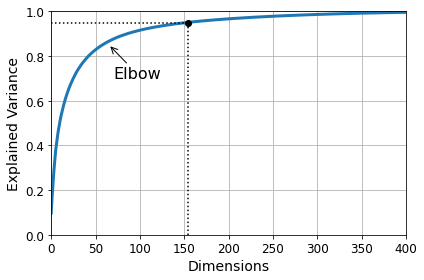

In [26]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

**<그림 8-8> 차원 수에 대한 함수로 나타낸 설명된 분산**  

위 그래프에는 일반적으로 설명된 분산의 빠른 성장이 멈추는 **변곡점**이 존재함. 따라서 이 데이터셋의 경우 꼭 154가 아니라 차원을 약 100 정도로 축소해도 설명된 분산을 크게 손해 보진 않을 것임

## 8.3.7 압축을 위한 PCA

PCA를 통해 압축된 데이터셋은 분류 알고리즘의 속도를 크게 높일 수 있음  
이렇게 압축된 데이터셋에 PCA 투영의 변환을 **반대로** 적용하여 원래의 784개의 차원(특성)으로 되돌리는 것도 가능함. BUT 투영 과정에서 일정량의 정보(유실된 5%의 분산)를 잃어버렸기 때문에 되돌린 것이 원본 데이터셋과 완전히 동일할 수는 없음  

**재구성 오차(reconstruction error)**: 위 과정에서 원본 데이터와 재구성된 데이터(압축 후 복원한 것) 사이의 평균 제곱 거리  

아래는 MNIST 데이터셋을 154 차원으로 압축하고 **inverse_transform()** 메소드를 사용해 다시 원래의 784 차원으로 복원하는 코드임

In [27]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

이를 그림으로 나타내면 아래와 같음

In [28]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일함:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가함:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합침 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합침:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 이제 출력하면 됨
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장 mnist_compression_plot


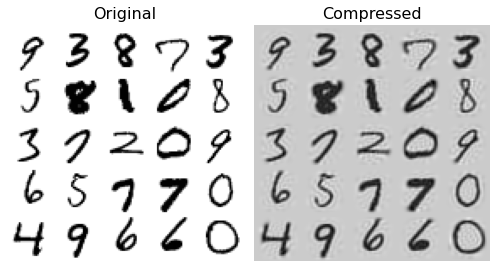

In [29]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

**<그림 8-9> 분산의 95%가 유지된 MNIST 압축**  

위 <그림 8-9>는 원본 훈련 세트(왼쪽)와 샘플을 압축한 후 복원한 결과(오른쪽)를 보여줌. 이미지 품질이 조금 손실된 것을 볼 수 있지만 숫자의 모양은 거의 온전한 상태임

In [30]:
# 뒤에서 다른 PCA와 비교할 때 쓸 용도로 X_reduced를 다른 변수에 저장
X_reduced_pca = X_reduced

## 8.3.8 랜덤 PCA

앞서 사용한 사이킷런의 PCA에서 **svd_solver 매개변수를 "randomized"로 지정**하면 **랜덤 PCA 알고리즘**을 사용할 수 있음 
* svd_solver의 기본값은 "auto"임, m이나 n이 500보다 크고 d가 m이나 n의 80%보다 작으면 사이킷런은 자동으로 랜덤 PCA 알고리즘을 사용함. 아니면 완전한 SVD 방식을 사용함)  

랜덤 PCA 알고리즘의 경우 d가 n보다 많이 작으면 완전한 SVD 방식보다 **훨씬 빠름**. 적용 코드는 아래와 같음

In [31]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## 8.3.9 점진적 PCA

PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 점임  
이 문제를 해결해주는 **점진적 PCA(IPCA, Incremental PCA)** 알고리즘이 개발되었음  
**점진적 PCA(IPCA, Incremental PCA)** 과정: 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입함

사이킷런의 `IncrementalPCA` 사용하기

In [32]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # 책에는 없음
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

`memmap()` 사용하기

`memmap()` 구조를 만들고 MNIST 데이터를 복사함. 이는 일반적으로 별도의 프로그램에서 먼저 수행됨

In [33]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

데이터가 디스크에 저장되었는지 확인하기 위해 `memmap()` 객체를 삭제

In [34]:
del X_mm

그리고 나서 다른 프로그램에서 데이터를 로드하여 훈련에 사용하면 아래와 같음

In [35]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

# 8.4 커널 PCA

**커널 PCA(kernel PCA, kPCA)**: 비선형 함수인 커널함수를 이용하여 비선형 데이터를 고차원 공간으로 매핑하여 PCA를 수행하는 것. **그리드 탐색**을 통해 좋은 커널과 하이퍼파라미터를 선택할 수 있음  

사이킷런의 **KernelPCA**를 사용해 RBF 커널로 kPCA를 적용하려면 아래와 같이 하면 됨

In [37]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

아래 코드로 출력한 <그림 8-10>은 선형 커널, RBF 커널, 시그모이드 커널을 사용하여 2차원으로 축소시킨 스위스 롤의 모습임

그림 저장 kernel_pca_plot


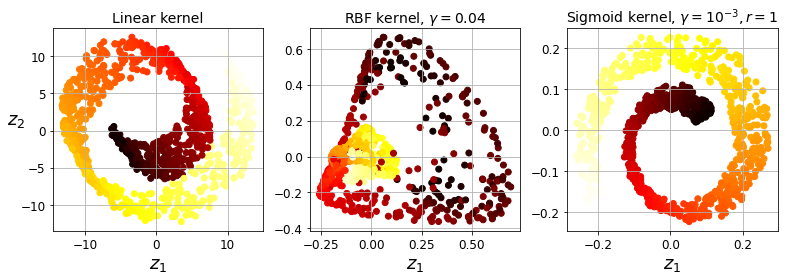

In [38]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

**<그림 8-10> 여러 가지 커널의 kPCA를 사용해 2D로 축소시킨 스위스 롤**

## 8.4.1 커널 선택과 하이퍼파라미터 튜닝

kPCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없지만, **그리드 탐색**을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있음  

아래 코드는 두 단계의 파이프라인을 만듦  
* 먼저 kPCA를 사용해 차원을 2차원으로 축소하고 분류를 위해 로지스틱 회귀를 적용함
* 그런 다음 파이프라인 마지막 단계에서 가장 높은 분류 정확도를 얻기 위해 **GridSearchCV**를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾음

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

가장 좋은 커널과 하이퍼파라미터는 아래와 같이 **best_params_** 변수에 저장됨

In [40]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


**재구성 원상(pre-image)**의 오차를 최소화하는 커널과 하이퍼파라미터를 선택하는 방법도 있음  
사이킷런에서는 아래와 같이 **fit_inverse_transform=True**로 지정하면 이를 자동으로 수행함

In [41]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

그러면 아래와 같이 **재구성 원상 오차**를 계산할 수 있음

In [42]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

1.9187246743845193e-26

이렇게 되면 재구성 원상 오차를 최소화하는 커널과 하이퍼파라미터를 찾기 위해 교차 검증으로 그리드 탐색을 사용할 수 있음

# 8.5 LLE

**LLE(지역 선형 임베딩, Locally Linear Embedding)**: 또 다른 강력한 **비선형 차원 축소** 기술. 투영에 의존하지 않는 매니폴드 학습에 해당함  

<LLE 과정>  
* 먼저 각 훈련 샘플이 가장 가까운 이웃(closest neighbor, c.n.)에 얼마나 선형적을 연관되어 있는지 측정
* 그 다음 국부적인 관계가 가장 잘 보존되는 훈련 세트의 저차원 표현을 찾음(이 방법은 특히 잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는 데 잘 작동함)  

아래 코드는 사이킷런의 **LocallyLinearEmbedding**을 사용해 스위스 롤을 펼침

In [53]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=40)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

결과 2D 데이터셋은 아래 그림을 통해 확인 가능

그림 저장 lle_unrolling_plot


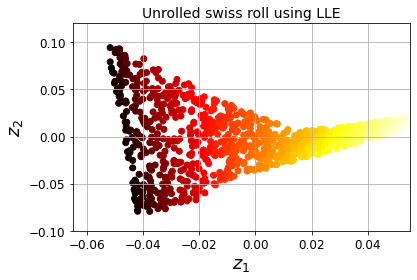

In [54]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

**<그림 8-12> LLE를 사용하여 펼쳐진 스위스 롤**  
위 그림을 보면 스위스 롤이 완전히 펼쳐졌고 지역적으로는 샘플 간 거리가 잘 보존되어 있음  
그러나 크게 보면 샘플 간 거리가 잘 유지되어 있지 않음. 펼쳐진 스위스 롤은 오른쪽은 압축되어 있고 왼쪽은 확장되어 있음  
그럼에도 불구하고 LLE는 매니폴드를 모델링하는 데 잘 동작함

# 8.6 다른 차원 축소 기법

### 랜덤 투영(random projection)  
: 랜덤한 선형 투영을 사용해 데이터를 저차원 공간으로 투영하는 기법

### 다차원 스케일링(Multidimensional Scaling, MDS)  
: 샘플 간의 거리를 보존하면서 차원을 축소하는 기법.  
코드로 구현하면 아래와 같음

In [55]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

### lsomap  
: 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만들고 난 뒤 샘플 간의 **지오데식 거리(geodesic distance)**를 유지하면서 차원을 축소하는 기법.  
코드로 구현하면 아래와 같음

In [56]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

### t-SNE(t-distributed Stochastic Neighbor Embedding)  
: 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소하는 기법. 주로 시각화에 많이 사용되며 특히 고차원 공간에 있는 샘플의 군집을 시각화할 때 사용됨.  
코드로 구현하면 아래와 같음 

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

### 선형 판별 분석(Linear Discriminant Analysis, LDA)  
: 분류 알고리즘이지만 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습하는 기법. 이 축은 데이터가 투영되는 초평면을 정의하는데 사용할 수 있음.  
코드로 구현하면 아래와 같음

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

위에서 살펴본 몇가지를 그래프로 시각화하면 아래와 같음

그림 저장 other_dim_reduction_plot


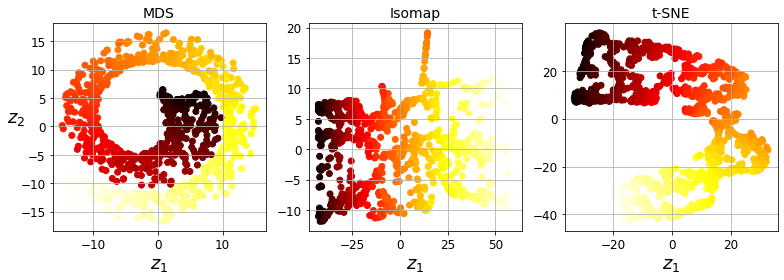

In [59]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

**<그림 8-13> 여러 가지 기법을 사용해 스위스 롤을 2D로 축소하기**  

# END